In [1]:
#Active environment should be cgcnn_matai
!conda info | grep 'cgcnn_matai'

     active environment : cgcnn_matai
    active env location : /home/hassan101/anaconda3/envs/cgcnn_matai


In [2]:
import pandas as pd
import json
import boto3
import io
import matplotlib.pyplot as plt
%matplotlib inline

import cgcnn_train_bg
import cgcnn_validation_bg
import fns_analysis
from fns_analysis import bg_master

import torch
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle
from scipy import optimize

import sys
import warnings


In [3]:
import os
MAPI_KEY = os.environ['MAPI_KEY']
aws_akid = os.environ['AWS_KID']
aws_sak = os.environ['AWS_AK']

In [4]:
res_s3 = boto3.resource('s3', aws_access_key_id=aws_akid, aws_secret_access_key= aws_sak)
client_s3 = boto3.client('s3', aws_access_key_id=aws_akid, aws_secret_access_key= aws_sak) 

bucket_name = 'datasets-cgcnn'

def load_from_s3(file_path):
    response = client_s3.get_object(Bucket=bucket_name, Key=file_path).get("Body")
    print("FILE LOADED")
    return response

def save_to_s3(df, file_path):
    with io.BytesIO() as output:
        with pd.ExcelWriter(output, engine='xlsxwriter') as writer:
            df.to_excel(writer)
        data = output.getvalue()
    client_s3.put_object(Bucket=bucket_name, Key=file_path, Body=data)
    print('FILE SAVED')

In [5]:
#Loading data
df_ds1 = pd.read_excel(io.BytesIO(load_from_s3('processed/processed_ds1.xlsx').read())).dropna(how='any').reset_index(drop=True)
df_ds2 = pd.read_excel(io.BytesIO(load_from_s3('processed/processed_ds2.xlsx').read())).dropna(how='any').reset_index(drop=True)
df_ds3 = pd.read_excel(io.BytesIO(load_from_s3('processed/processed_ds3.xlsx').read())).dropna(how='any').reset_index(drop=True)

FILE LOADED
FILE LOADED
FILE LOADED


In [6]:
#Pretrained base model
m1_main_path = 'saved_models/m1_150-200epochs.pth.tar'

path_to_cif_folder = os.path.join(os.path.dirname(os.getcwd()),'master_files/cif_master')
path_to_init_file = os.path.join(os.path.dirname(os.getcwd()),'master_files/cgcnn_atom_init/atom_init.json')

Developing target model

In [ ]:
# Running in loop with random shuffling

def shuffle_run(num_of_runs):
    
    global loop
    loop = pd.DataFrame(data = np.zeros(shape=(num_of_runs,5)), columns=['RS', 'MAE_train', 'MAE_modval', 'MAE_test','MAE_val_main'])
    
    for i in range(0,num_of_runs,1):
        print('\nRun: {}/{}'.format(i,num_of_runs))
        
        m2_train = df_ds2[['mpids','bg_exp']]
        m2_train_shuffled = shuffle(m2_train, random_state=i)
        
        # Ignore warnings
        warnings.filterwarnings("ignore")
        
        #Block print
        sys.stdout = open(os.devnull, 'w')
    
        m2_train_performance, m2_trained_model,m2_batch_train, m2_batch_modval, m2_history = cgcnn_train_bg.execute_resume(
                mpids_bg = m2_train_shuffled,
                cif_folder = path_to_cif_folder,    
                init_file = path_to_init_file,
                train_ratio = 0.85,
                val_ratio = 0.10,
                epochs = 50, #Do atleast 3 epochs otherwise av will fail in loop df
                learning_rate = 0.01,
                max_nbrs = 14, radius = 7,
                model_path = m1_main_path,
                randomize = False  
                )
        
        #enable print
        sys.stdout = sys.__stdout__

        # Pred with M2 for validation
        df_pred, _= cgcnn_validation_bg.predict(
                mpids_pred = df_ds3[['mpids']],
                model_pred = m2_trained_model,
                cif_folder = path_to_cif_folder,  
                init_file = path_to_init_file,
                max_nbrs = 14, radius = 7  
                )

        loop.loc[i]['RS'] = i
        # loop.loc[i]['MAE_train'] = m2_history.loc[m2_history.index[-3:], "mae_train"].mean() #Taking av of last 3 iterations
        # loop.loc[i]['MAE_modval'] = m2_history.loc[m2_history.index[-3:], "mae_val"].mean() #Taking av of last 3 iterations
        loop.loc[i]['MAE_train'] = m2_history.loc[m2_history.index[-1], "mae_train"]
        loop.loc[i]['MAE_modval'] = m2_history.loc[m2_history.index[-1], "mae_val"]
        loop.loc[i]['MAE_test'] = mean_absolute_error(m2_train_performance['target'].values , m2_train_performance['pred'].values)
        loop.loc[i]['MAE_val_main'] = mean_absolute_error(df_pred['pred'], df_ds3['bg_exp'])
        print(loop.loc[i])
    
    return

# Shuffling loop
shuffle_run(num_of_runs = 1000) #RS

loop.to_excel('loop_50epochs.xlsx')

Brute optimization of the grid to find the best parametric combination

In [ ]:
def grid_search(x):
    
    epoch_gs,random_state,train_ratio, val_ratio,learning_rate = int(x[0]),int(x[1]),x[2],x[3],x[4]
    max_nbrs, radius = 14, 7
    
    m2_train = df_ds2[['mpids','bg_exp']]
    m2_train_shuffled = shuffle(m2_train, random_state=random_state)
    
    # Ignore warnings
    warnings.filterwarnings("ignore")
    
    print('Training M2')
    
    #Block print
    sys.stdout = open(os.devnull, 'w')
    
    m2_train_performance, m2_trained_model,m2_batch_train, m2_batch_modval, m2_history = cgcnn_train_bg.execute_resume(
            mpids_bg = m2_train_shuffled,
            cif_folder = path_to_cif_folder,    
            init_file = path_to_init_file,
            train_ratio = train_ratio,
            val_ratio = val_ratio,
            epochs = epoch_gs, #Do atleast 3 epochs otherwise av will fail in loop df
            learning_rate = learning_rate,
            max_nbrs = max_nbrs, radius = radius,
            model_path = m1_main_path,
            randomize = False  
            )
    
    #enable print
    sys.stdout = sys.__stdout__

    df_pred, _= cgcnn_validation_bg.predict(
            mpids_pred = df_ds3[['mpids']],
            model_pred = m2_trained_model,
            cif_folder = path_to_cif_folder,    
            init_file = path_to_init_file,
            max_nbrs = max_nbrs, radius = radius
            )
    
    #global output
    #output = [epoch_gs,random_state,train_ratio, val_ratio,learning_rate, m2_history.loc[m2_history.index[-1], "mae_train"],m2_history.loc[m2_history.index[-1], "mae_val"],mean_absolute_error(m2_train_performance['target'].values , m2_train_performance['pred'].values),mean_absolute_error(df_pred['pred'], df_ds3['bg_exp'])]
    
    MAE_val = (mean_absolute_error(df_pred['pred'], df_ds3['bg_exp']))
    print(int(x[0]),int(x[1]),x[2],x[3],x[4])
    print('MAE_val:', MAE_val)

    return MAE_val

epoch_slice = slice(10, 50, 5)
random_state_slice = slice(0, 10, 1)
train_ratio_slice = slice(0.8, 0.90, 0.05)
val_ratio_slice = slice(0.05, 0.10, 0.05)
learning_rate_slice = slice(0.001, 0.02, 0.01)

rranges = (epoch_slice, random_state_slice,train_ratio_slice,val_ratio_slice,learning_rate_slice)
resbrute = optimize.brute(func=grid_search, ranges=rranges, full_output=True,finish=None)

Once hyperparameters are estimated, the process can be repeated with the best combination

In [27]:
def single_run(x):
        
    epoch,random_state,train_ratio, val_ratio,learning_rate = int(x[0]),int(x[1]),x[2],x[3],x[4]
    max_nbrs, radius = 14, 7
    
    m2_train = df_ds2[['mpids','bg_exp']]
    m2_train_shuffled = shuffle(m2_train, random_state=random_state)
    
    
    # Ignore warnings
    warnings.filterwarnings("ignore")
    
    print('Training M2')
    
    # #Block print
    # sys.stdout = open(os.devnull, 'w')
    
    global m2_trained_model, m2_history
    m2_train_performance, m2_trained_model,m2_batch_train, m2_batch_modval, m2_history = cgcnn_train_bg.execute_resume(
            mpids_bg = m2_train_shuffled,
            cif_folder = path_to_cif_folder,    
            init_file = path_to_init_file,
            train_ratio = train_ratio,
            val_ratio = val_ratio,
            epochs = epoch,
            learning_rate = learning_rate,
            max_nbrs = max_nbrs, radius = radius,
            model_path = m1_main_path,
            randomize = False  
            )
    
    # #enable print
    # sys.stdout = sys.__stdout__

    df_pred, _= cgcnn_validation_bg.predict(
            mpids_pred = df_ds3[['mpids']],
            model_pred = m2_trained_model,
            cif_folder = path_to_cif_folder,    
            init_file = path_to_init_file,
            max_nbrs = max_nbrs, radius = radius
            )
    
    global df_m2
    df_m2 = df_ds2.copy()
    for i in range(len(df_m2)):
        if df_m2.loc[i]['mpids']  in m2_batch_train.cif_id.values:
            df_m2.at[i,'Dataset'] = 'Train'
        if df_m2.loc[i]['mpids']  in m2_batch_modval.cif_id.values:
            df_m2.at[i,'Dataset'] = 'Val'
        if df_m2.loc[i]['mpids']  in m2_train_performance.cif_id.values:
            df_m2.at[i,'Dataset'] = 'Test' 
            
    
    output = {
        'epoch':epoch,
         'RS':random_state,
         'train_ratio':train_ratio, 
         'val_ratio':val_ratio,
         'learning_rate':learning_rate, 
         'mae_train':m2_history.loc[m2_history.index[-1], "mae_train"],
         'mae_valmod':m2_history.loc[m2_history.index[-1], "mae_val"],
         'mae_test':mean_absolute_error(m2_train_performance['target'].values , m2_train_performance['pred'].values),
         'mae_val_main':mean_absolute_error(df_pred['pred'], df_ds3['bg_exp'])
         }    
 
    MAE_val_main = (mean_absolute_error(df_pred['pred'], df_ds3['bg_exp']))
    print('MAE_val:', MAE_val_main)
          
    global df_validation_m1m2
    df_validation_m1m2 = df_ds3.copy()
    df_pred_m1, _ = cgcnn_validation_bg.predict(
            mpids_pred = df_ds3[['mpids']],
            model_pred = torch.load(m1_main_path),
            cif_folder = path_to_cif_folder,    
            init_file = path_to_init_file,
            max_nbrs = 14, radius = 7  
            )
    df_validation_m1m2['bg_pred_m1'] = df_pred_m1['pred']
    df_validation_m1m2['bg_pred_m2'] = df_pred['pred']

    return output

params = [50, #epochs
          464, #RS
          0.75, #Train ratio
          0.15, #Val ratio
          0.01 #Learning rate
          ]
result = single_run(params)

#Saving model and metrics

torch.save(m2_trained_model,'saved_models/m2-rsX/m2-rsX_50epoch.pth.tar')
df_m2.to_excel('saved_models/m2-rsX/dataset.xlsx')
m2_history.to_excel('saved_models/m2-rsX/history.xlsx')
df_validation_m1m2.to_excel('saved_models/m2-rsX/dataset_validation.xlsx')

with open('saved_models/m2-rsX/metrics_50epoch.txt', 'w') as f:
    for key, value in result.items(): 
        f.write('%s:%s\n' % (key, value))

In [28]:
display(df_m2.head())
display(m2_history.head())
display(df_validation_m1m2.head())

,Unnamed: 0,mpids,formula,bg_mp,bg_exp,Dataset
0,0,mp-390,TiO2,2.0625,3.20,Train
1,1,mp-2657,TiO2,1.7719,3.02,Train
2,2,mp-32777,WO3,1.2338,2.76,Train
3,3,mp-619461,WO3,1.3712,2.73,Val
4,4,mvc-5096,WO3,1.4306,2.75,Train


,epoch,mae_train,mae_val,mae_test
0,200.0,0.612729,0.745523,0.695583
1,201.0,0.554547,0.621937,0.575659
2,202.0,0.484065,0.543293,0.485564
3,203.0,0.440881,0.515096,0.445229
4,204.0,0.406684,0.491396,0.416116


,Unnamed: 0,mpids,formula,sg,bg_mp,bg_exp,bg_hse,bg_gw,bg_pred_m1,bg_pred_m2
0,0,mp-1550,AlP,216,1.8232,2.45,2.33,2.67,1.870360,2.236310
1,1,mp-2624,AlSb,216,1.2605,1.60,1.88,1.94,1.084754,1.137371
2,2,mp-10044,BAs,216,1.2522,1.50,1.86,2.20,1.186135,1.566688
3,3,mp-422,BeS,216,3.2356,4.17,4.10,4.92,3.005864,3.881305
4,4,mp-1541,BeSe,216,2.8976,3.61,3.54,4.19,3.234007,3.823602


In [9]:
# Validation check
m2_trained_model = torch.load('saved_models/m2-rsX/m2-rsX_50epoch.pth.tar')

df_pred, _= cgcnn_validation_bg.predict(
        mpids_pred = df_ds3[['mpids']],
        model_pred = m2_trained_model,
        cif_folder = path_to_cif_folder,    
        init_file = path_to_init_file,
        max_nbrs = 14, radius = 7  
        )
print('MAE_val:',mean_absolute_error(df_pred['pred'], df_ds3['bg_exp']))


Loading model
=> loaded model (epoch 250, validation 0.3980681896209717)
Test: [0/1]	Time 0.079 (0.079)	Loss 2.9578 (2.9578)	MAE 2.199 (2.199)
 ** MAE 2.199
MAE_val: 0.2340935918490092


/home/hassan101/anaconda3/envs/cgcnn_matai/lib/python3.11/site-packages/pymatgen/io/cif.py:1165: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


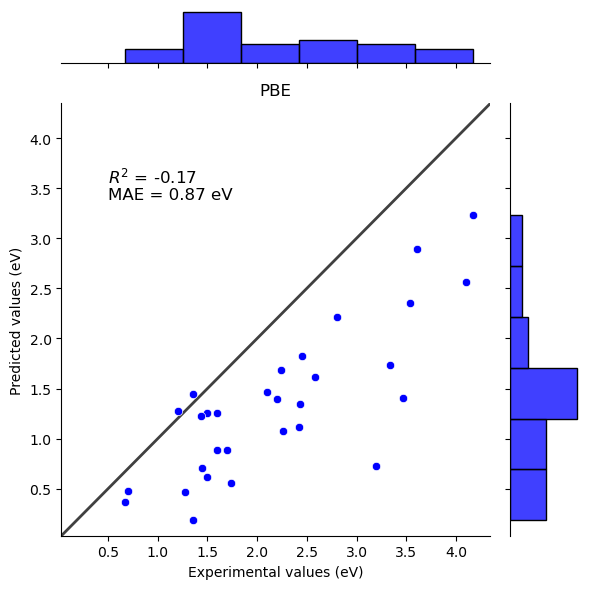

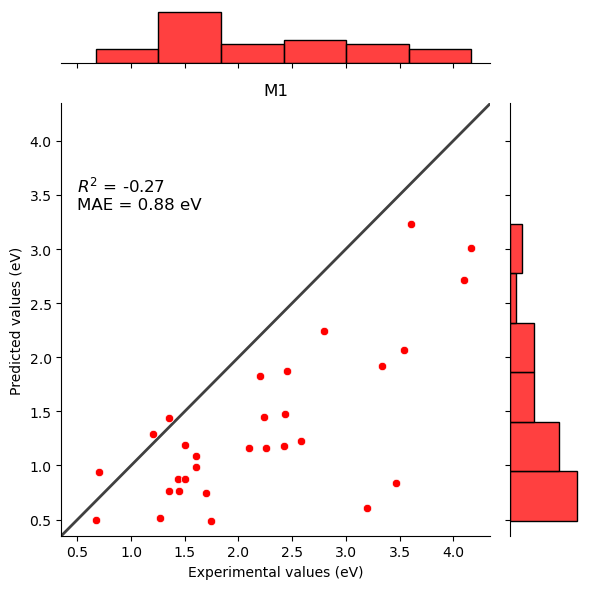

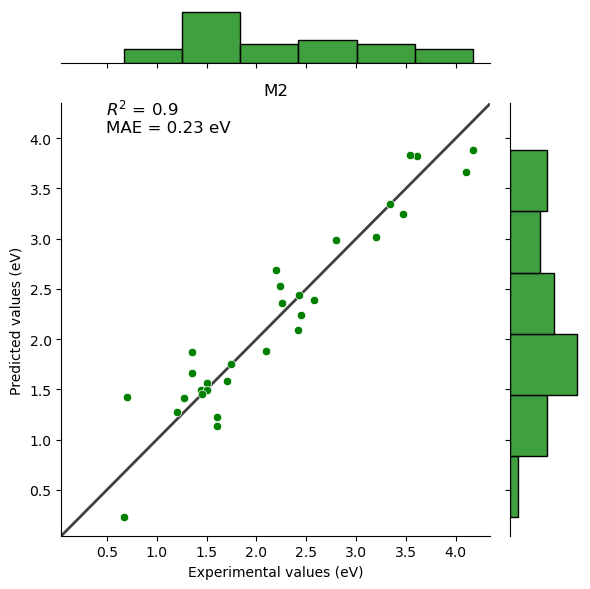

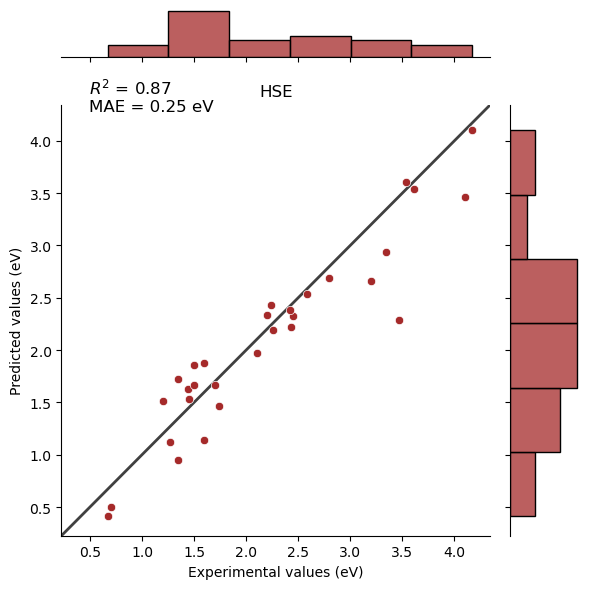

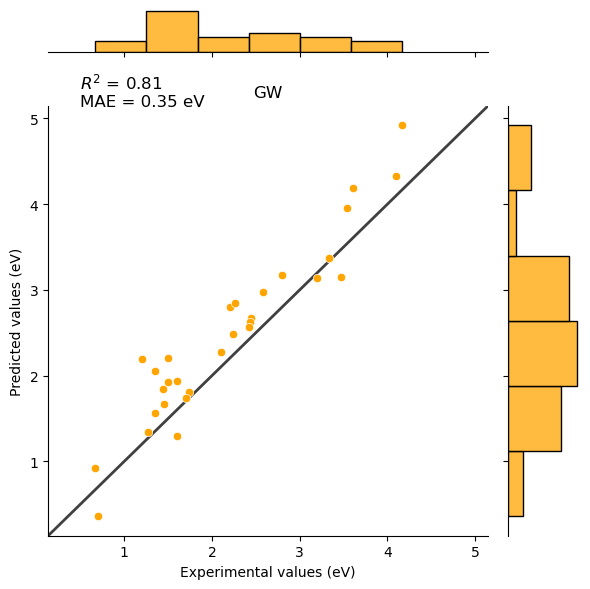

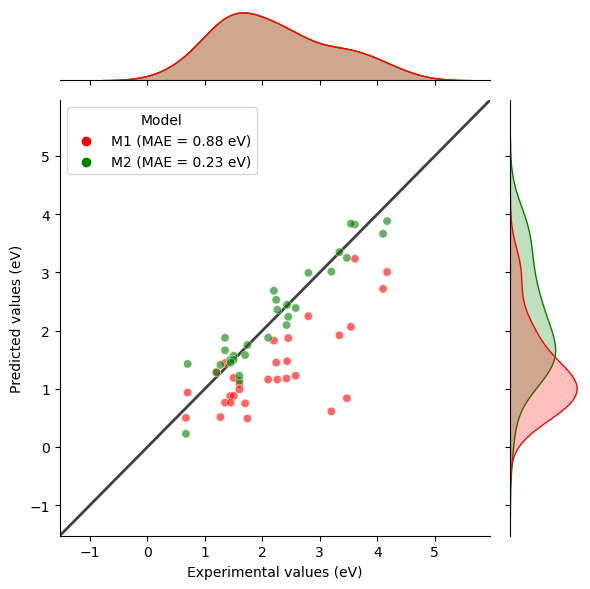

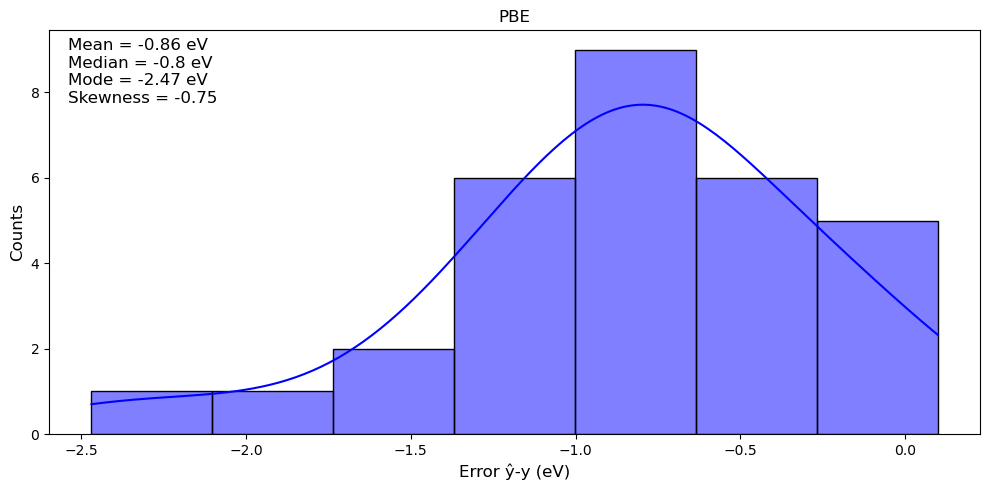

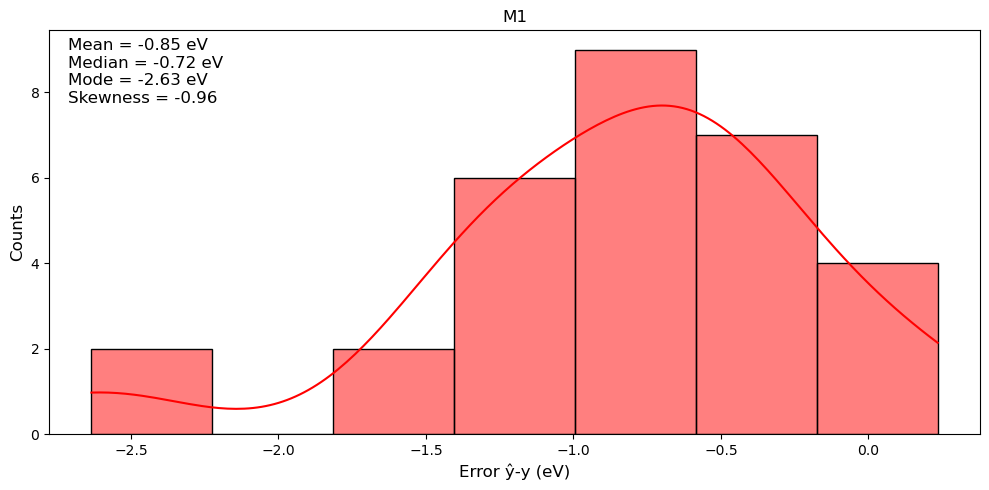

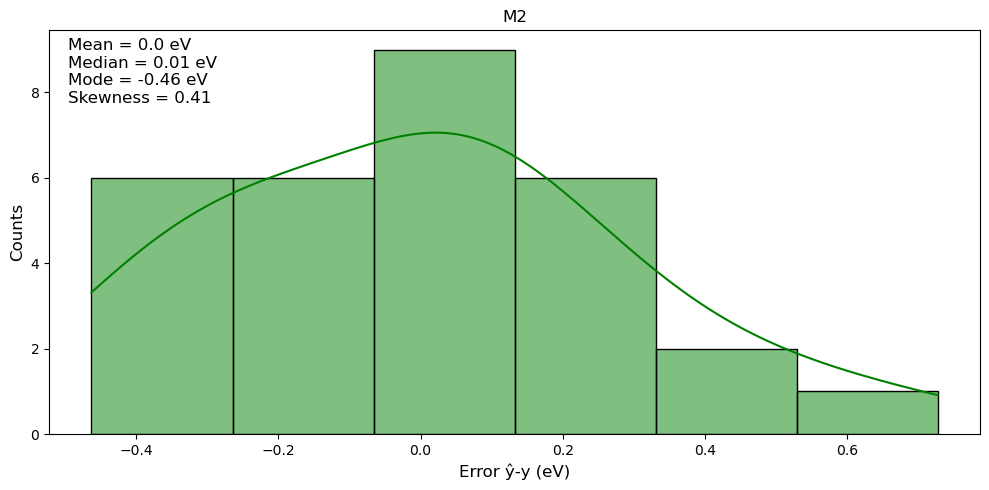

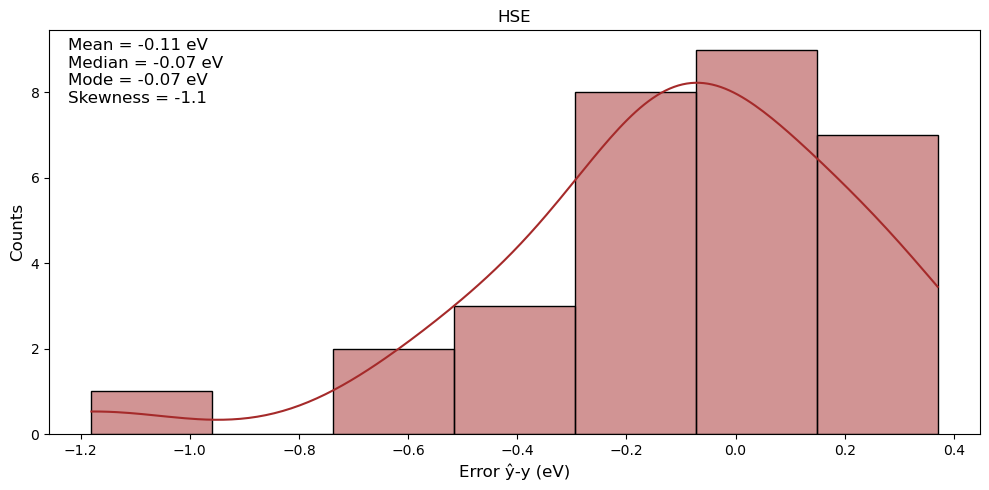

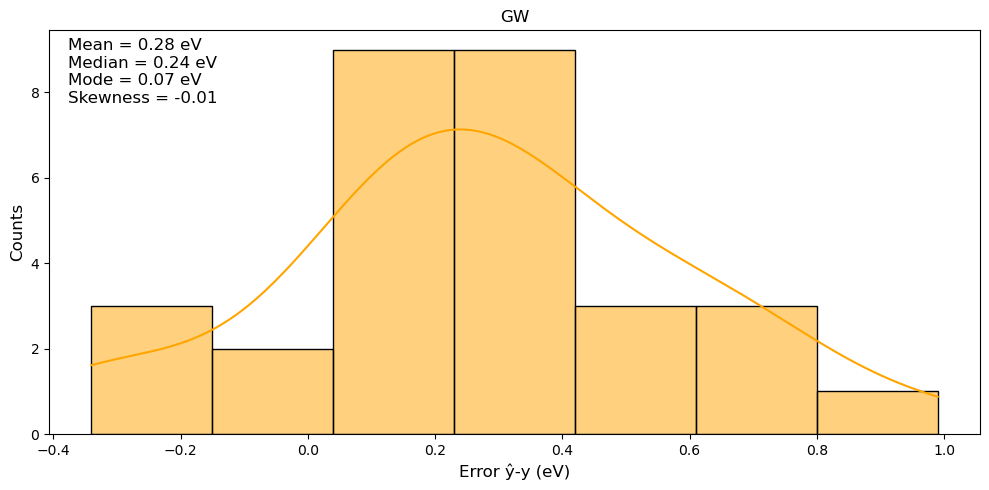

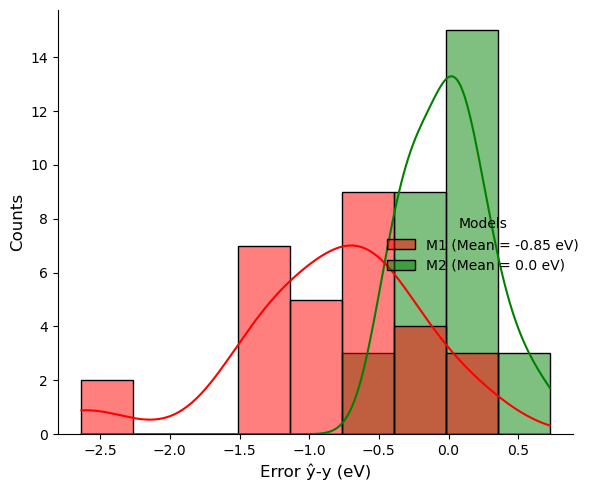

In [41]:
#Plotting M2 trained by domain adaptation
df_validation_m1m2 = pd.ExcelFile('saved_models/m2-rsX/dataset_validation.xlsx').parse('Sheet1')

bg_exp = df_validation_m1m2['bg_exp']
bg_mp =  df_validation_m1m2['bg_mp']
bg_hse = df_validation_m1m2['bg_hse']
bg_gw = df_validation_m1m2['bg_gw']
bg_m1 = df_validation_m1m2['bg_pred_m1']
bg_m2 = df_validation_m1m2['bg_pred_m2']

mpids = df_validation_m1m2['mpids']

ax_symbol = 'eV'

bg_master(bg_exp, bg_mp, bg_hse, bg_gw, bg_m1, bg_m2,
                ax_symbol = ax_symbol
                )

In [35]:
# M2 from scratch
def m2_from_scratch(x):
        
    epoch,random_state,train_ratio, val_ratio,learning_rate = int(x[0]),int(x[1]),x[2],x[3],x[4]
    max_nbrs, radius = 14, 7

    m2_train = df_ds2[['mpids','bg_exp']]
    m2_train_shuffled = shuffle(m2_train, random_state=random_state)
    
        # Ignore warnings
    warnings.filterwarnings("ignore")
    
    print('Training M2')
    
    # #Block print
    # sys.stdout = open(os.devnull, 'w')
    
    global m2_trained_model, m2_history
    m2_train_performance, m2_trained_model,m2_batch_train, m2_batch_modval, m2_history = cgcnn_train_bg.execute(
            mpids_bg = m2_train_shuffled,
            cif_folder = path_to_cif_folder,    
            init_file = path_to_init_file,
            train_ratio = train_ratio,
            val_ratio = val_ratio,
            epochs = epoch,
            learning_rate = learning_rate,
            max_nbrs = max_nbrs, radius = radius,
            randomize = False  
            )
    
    # #enable print
    # sys.stdout = sys.__stdout__

    df_pred, _= cgcnn_validation_bg.predict(
            mpids_pred = df_ds3[['mpids']],
            model_pred = m2_trained_model,
            cif_folder = path_to_cif_folder,    
            init_file = path_to_init_file,
            max_nbrs = max_nbrs, radius = radius
            )
    
    global df_m2
    df_m2 = df_ds2.copy()
    for i in range(len(df_m2)):
        if df_m2.loc[i]['mpids']  in m2_batch_train.cif_id.values:
            df_m2.at[i,'Dataset'] = 'Train'
        if df_m2.loc[i]['mpids']  in m2_batch_modval.cif_id.values:
            df_m2.at[i,'Dataset'] = 'Val'
        if df_m2.loc[i]['mpids']  in m2_train_performance.cif_id.values:
            df_m2.at[i,'Dataset'] = 'Test' 
            
    
    output = {
        'epoch':epoch,
         'RS':random_state,
         'train_ratio':train_ratio, 
         'val_ratio':val_ratio,
         'learning_rate':learning_rate, 
         'mae_train':m2_history.loc[m2_history.index[-1], "mae_train"],
         'mae_valmod':m2_history.loc[m2_history.index[-1], "mae_val"],
         'mae_test':mean_absolute_error(m2_train_performance['target'].values , m2_train_performance['pred'].values),
         'mae_val_main':mean_absolute_error(df_pred['pred'], df_ds3['bg_exp']),

         }    
 
    MAE_val_main = (mean_absolute_error(df_pred['pred'], df_ds3['bg_exp']))
    print('MAE_val:', MAE_val_main)

    global df_validation_m1m2
    df_validation_m1m2 = df_ds3.copy()
    df_pred_m1, _ = cgcnn_validation_bg.predict(
            mpids_pred = df_ds3[['mpids']],
            model_pred = torch.load(m1_main_path),
            cif_folder = path_to_cif_folder,    
            init_file = path_to_init_file,
            max_nbrs = 14, radius = 7  
            )
    df_validation_m1m2['bg_pred_m1'] = df_pred_m1['pred']
    df_validation_m1m2['bg_pred_m2'] = df_pred['pred']

    return output

params = [50, #epochs
          464, #RS
          0.75, #Train ratio
          0.15, #Val ratio
          0.01 #Learning rate
          ]

result = m2_from_scratch(params)

torch.save(m2_trained_model,'saved_models/m2-scratch/m2-scratch_50epoch.pth.tar')
df_m2.to_excel('saved_models/m2-scratch/dataset.xlsx')
m2_history.to_excel('saved_models/m2-scratch/history.xlsx')
df_validation_m1m2.to_excel('saved_models/m2-scratch/dataset_validation.xlsx')

with open('saved_models/m2-scratch/metrics_50epoch.txt', 'w') as f:
    for key, value in result.items(): 
        f.write('%s:%s\n' % (key, value))

display(df_m2.head())
display(m2_history.head())
display(df_validation_m1m2.head())

,Unnamed: 0,mpids,formula,bg_mp,bg_exp,Dataset
0,0,mp-390,TiO2,2.0625,3.20,Train
1,1,mp-2657,TiO2,1.7719,3.02,Train
2,2,mp-32777,WO3,1.2338,2.76,Train
3,3,mp-619461,WO3,1.3712,2.73,Val
4,4,mvc-5096,WO3,1.4306,2.75,Train


,epoch,mae_train,mae_val,mae_test
0,0.0,0.884951,3.382907,3.659879
1,1.0,0.846179,0.803336,0.841404
2,2.0,0.844140,0.851962,1.013386
3,3.0,0.714248,0.830548,0.987098
4,4.0,0.710804,0.846035,0.818183


,Unnamed: 0,mpids,formula,sg,bg_mp,bg_exp,bg_hse,bg_gw,bg_pred_m1,bg_pred_m2
0,0,mp-1550,AlP,216,1.8232,2.45,2.33,2.67,1.870360,3.270221
1,1,mp-2624,AlSb,216,1.2605,1.60,1.88,1.94,1.084754,1.863011
2,2,mp-10044,BAs,216,1.2522,1.50,1.86,2.20,1.186135,2.992581
3,3,mp-422,BeS,216,3.2356,4.17,4.10,4.92,3.005864,3.527793
4,4,mp-1541,BeSe,216,2.8976,3.61,3.54,4.19,3.234007,3.779743


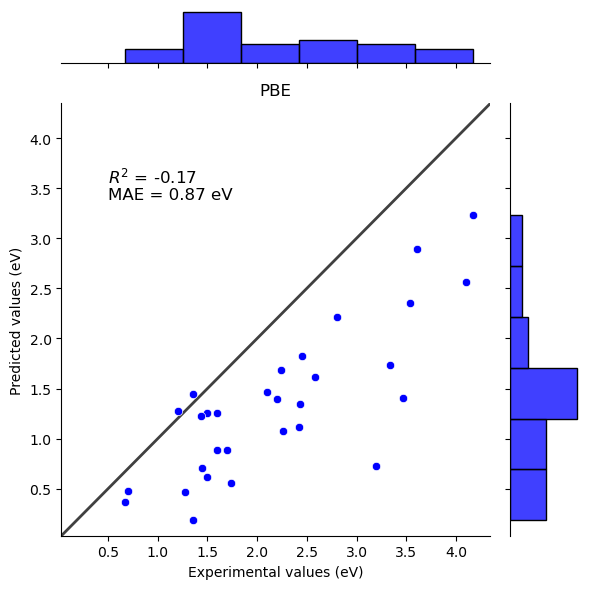

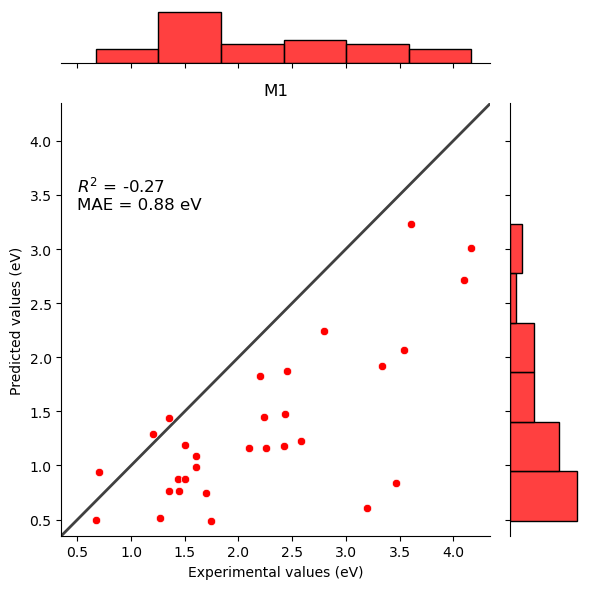

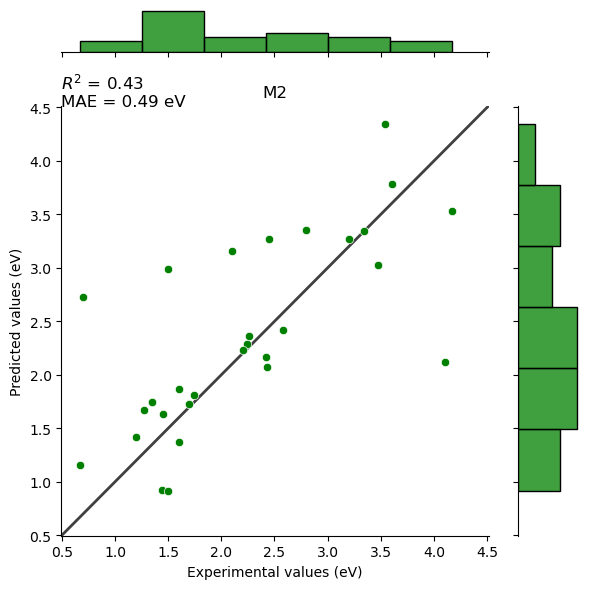

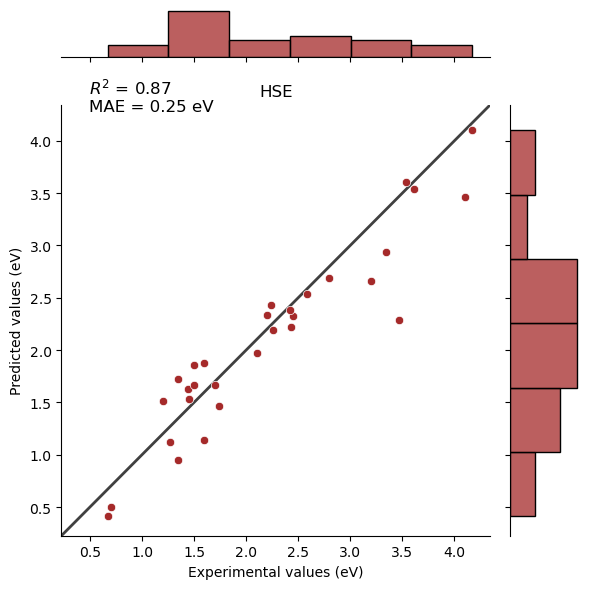

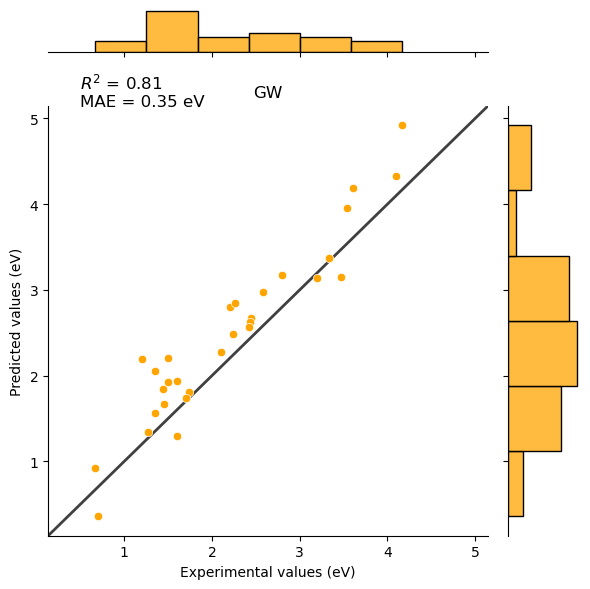

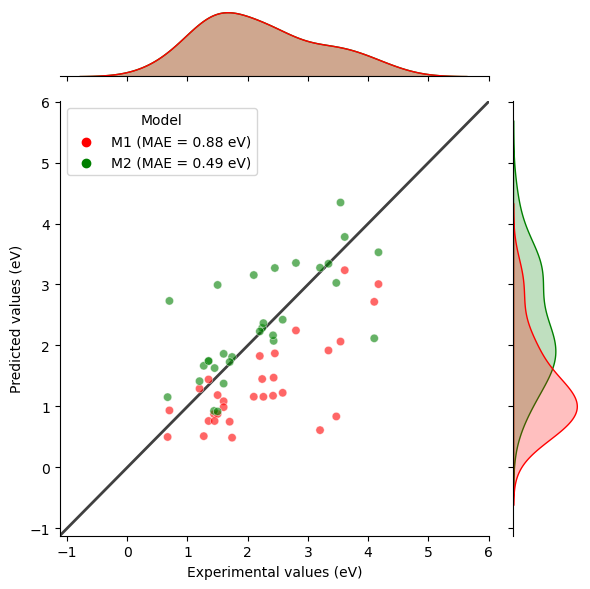

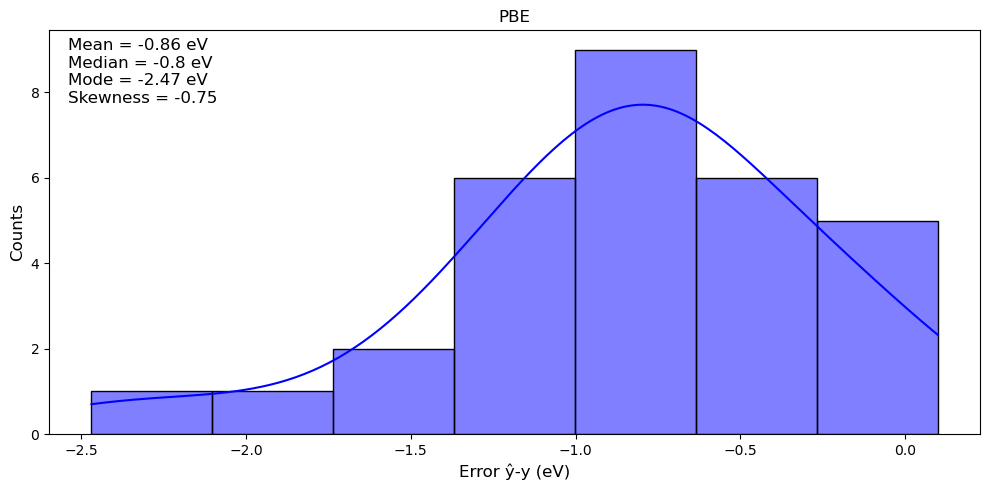

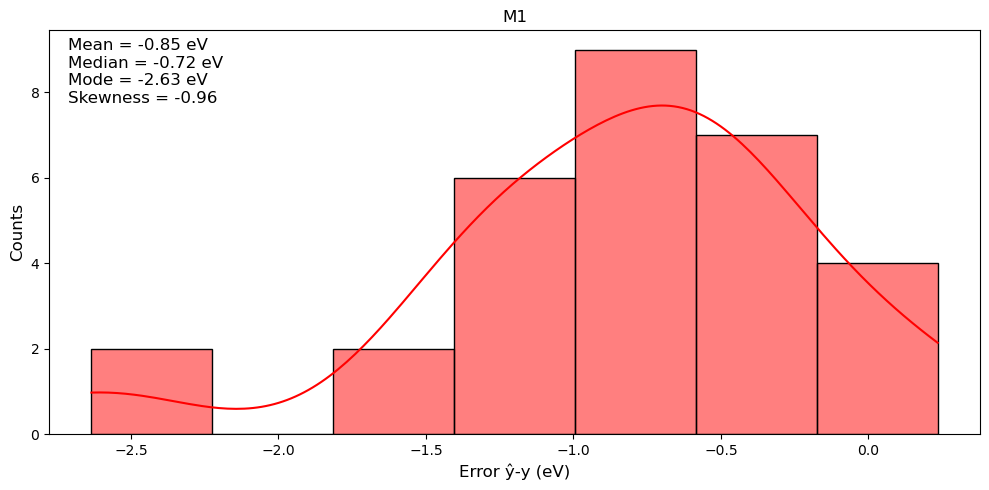

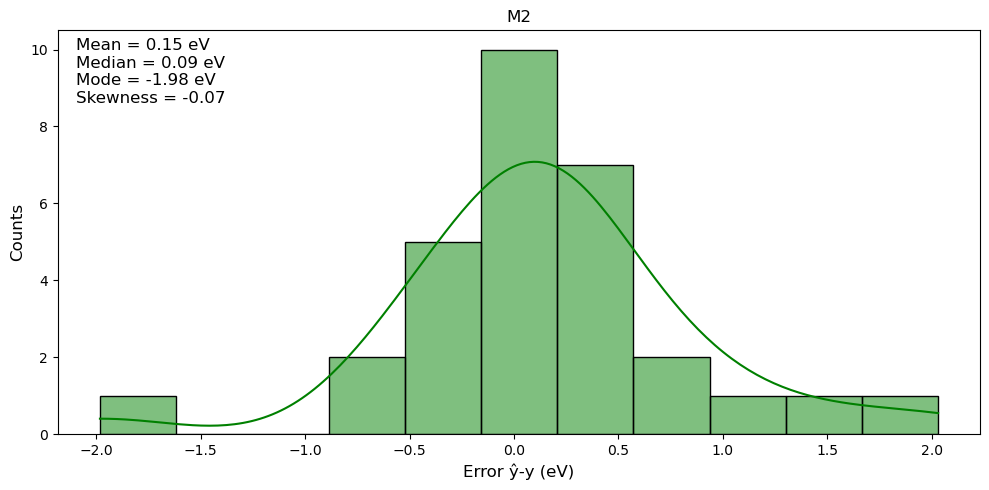

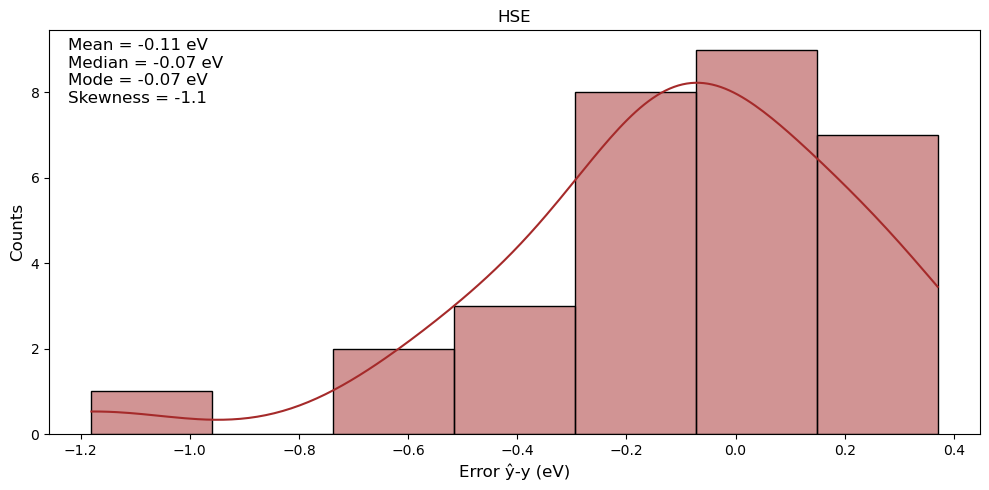

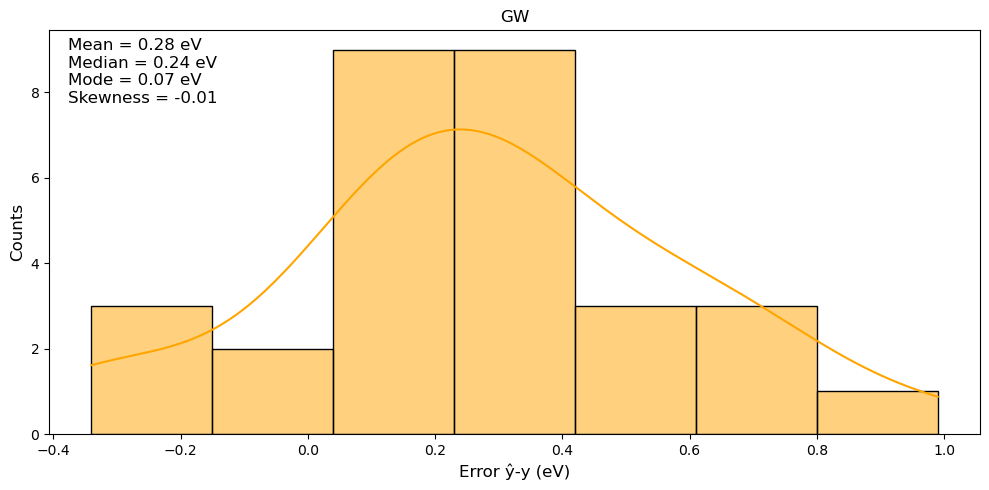

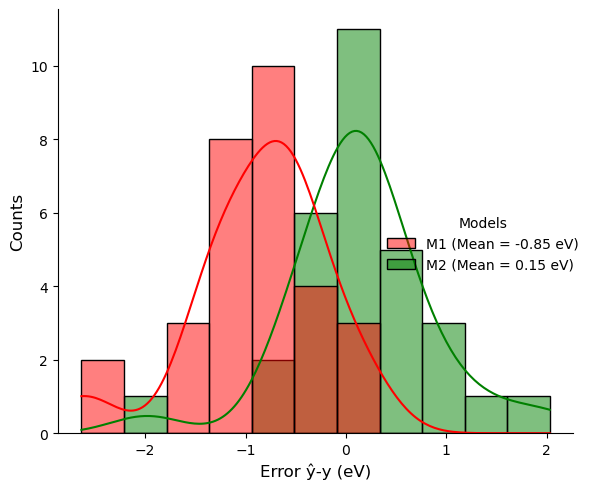

In [40]:
#Plotting M2 trained from scratch
df_validation_m1m2 = pd.ExcelFile('saved_models/m2-scratch/dataset_validation.xlsx').parse('Sheet1')

bg_exp = df_validation_m1m2['bg_exp']
bg_mp =  df_validation_m1m2['bg_mp']
bg_hse = df_validation_m1m2['bg_hse']
bg_gw = df_validation_m1m2['bg_gw']
bg_m1 = df_validation_m1m2['bg_pred_m1']
bg_m2 = df_validation_m1m2['bg_pred_m2']

mpids = df_validation_m1m2['mpids']

ax_symbol = 'eV'

bg_master(bg_exp, bg_mp, bg_hse, bg_gw, bg_m1, bg_m2,
                ax_symbol = ax_symbol
                )

The earlier plots show M2 developed after domain adaptation from base M1 outperformed M2 developed from scratch in the latter plots.

- Blue: PBE band gaps
- Red: M1 predictions
- Green: M2 predictions
- Brown: HSE band gaps
- Orange: GW band gaps
    
The errors are calculated relative to experimental band gaps.